# Synthetic Data Generation using WGAN-GP

## Problem Statement

**Problem**: Real-world fraud detection datasets are often limited, imbalanced, and sensitive to privacy concerns. Training machine learning models on limited data leads to poor generalization and overfitting.

**Solution**: Generate synthetic fraud detection data that:
1. Preserves statistical properties (distributions, correlations) of real data
2. Maintains feature relationships and dependencies
3. Produces realistic samples indistinguishable from real data
4. Enables data augmentation without privacy violations

**Why WGAN-GP?**
- **Stable Training**: Wasserstein loss provides meaningful gradients even when fake and real distributions don't overlap
- **No Mode Collapse**: Gradient penalty prevents generator from producing limited variety
- **Better Convergence**: Lipschitz constraint ensures smooth discriminator surface
- **Scalability**: Works well with continuous features typical in fraud datasets

This notebook implements a complete WGAN-GP pipeline: data preprocessing, model training, synthetic data generation, and comprehensive quality evaluation.

## Overview

This project demonstrates synthetic data generation using WGAN-GP methodology.

### Import Required Libraries

This cell imports all necessary libraries for:
- **Data Processing**: pandas, numpy for handling datasets
- **Visualization**: matplotlib, seaborn for plots
- **Preprocessing**: MinMaxScaler for data normalization
- **Deep Learning**: PyTorch for model implementation
- **Evaluation**: scikit-learn for metrics and testing
- **Statistical Analysis**: scipy for distribution divergence calculations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset
from scipy.spatial.distance import jensenshannon
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Load and Preprocess Data

This cell:
- Loads raw fraud detection data from Excel file
- Scales data to [-1, 1] range required for neural network training
- Normalizes feature values using MinMaxScaler to prevent activation saturation
- Displays data samples and statistical summaries for inspection

In [ ]:
# Load and preprocess data
data = pd.read_excel("data.xlsx")
scaler = MinMaxScaler(feature_range=(-1, 1))
real_data = scaler.fit_transform(data.values.astype(np.float32))
display(data.head())
print("\n\n",data.describe())

,cov1,cov2,cov3,cov4,cov5,cov6,cov7,sal_pur_rat,igst_itc_tot_itc_rat,lib_igst_itc_rat
0,0.997797,0.999888,0.215934,0.196713,0.000000,0.955616,0.998810,-0.032581,1.761759,-0.054329
1,0.994004,0.979902,-0.337135,-0.248634,0.000000,0.640812,0.553918,-0.032026,-0.629311,-0.053516
2,0.947603,0.455667,0.001743,0.128610,-0.004054,-0.162069,0.960601,-0.030209,1.535697,-0.054215
3,0.396577,0.919933,0.496451,0.576824,-0.340718,0.802363,0.673710,-0.032058,0.449160,-0.054126
4,0.999893,0.327615,0.700477,0.315601,0.000000,0.300785,0.979009,-0.032224,1.762049,-0.054330




               cov1         cov2         cov3         cov4         cov5  \
count  1199.000000  1199.000000  1199.000000  1199.000000  1199.000000   
mean      0.956896     0.855770     0.214263     0.147359     0.036329   
std       0.135031     0.244927     0.408193     0.388080     0.177615   
min      -0.312219    -0.531958    -0.818128    -0.839158    -0.719622   
25%       0.982505     0.840675    -0.095193    -0.143054     0.000000   
50%       0.999235     0.969806     0.175910     0.097584     0.000000   
75%       0.999993     0.996604     0.563061     0.457633     0.000000   
max       1.000000     1.000000     1.000000     0.979015     0.999196   

              cov6         cov7   sal_pur_rat  igst_itc_tot_itc_rat  \
count  1199.000000  1199.000000  1.199000e+03          1.199000e+03   
mean      0.599809     0.527768 -1.251042e-11         -5.004165e-12   
std       0.334306     0.385322  1.000000e+00          1.000000e+00   
min      -0.682734    -0.859529 -3.531330e-02 

### Define Hyperparameters

This cell configures training parameters:
- **latent_dim (32)**: Size of random noise vector fed to generator
- **batch_size (64)**: Training batch size for stable gradient estimation
- **n_critic (10)**: Train discriminator 10x per generator update for convergence
- **lambda_gp (10)**: Balances gradient penalty in Wasserstein loss
- **epochs (1200)**: Number of complete training iterations
- **device**: Automatically uses GPU if available, CPU otherwise

In [ ]:
# Hyperparameters - optimized through experimentation
latent_dim = 32  # Dimension of random noise input to generator
batch_size = 64  # Number of samples per training batch
n_critic = 10    # Number of discriminator updates per generator update
lambda_gp = 10   # Gradient penalty weight (Lipschitz constraint strength)
epochs = 1200    # Total training epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Model Architecture and Training

This cell defines and trains the WGAN-GP model:
- **Generator**: Transforms 32D random noise → synthetic data samples (3 hidden layers)
- **Discriminator (Critic)**: Evaluates real vs fake data (3 hidden layers)
- **Gradient Penalty**: Enforces smooth discriminator for stable training
- **Training Loop**: Uses 10:1 discriminator-to-generator update ratio
- **Loss**: Wasserstein distance with gradient penalty penalty

In [ ]:
# DataLoader
dataset = TensorDataset(torch.tensor(real_data))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator - transforms random noise to synthetic data
class Generator(nn.Module):
    def __init__(self, z_dim, data_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, data_dim),
            nn.Tanh()  # Output bounded to [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

# Discriminator (Critic) - evaluates real vs synthetic data authenticity
class Discriminator(nn.Module):
    def __init__(self, data_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)  # Outputs Wasserstein distance estimate
        )

    def forward(self, x):
        return self.model(x)

# Gradient penalty function - enforces 1-Lipschitz constraint
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    alpha = alpha.expand_as(real_samples)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    gradients = grad(outputs=d_interpolates, inputs=interpolates,
                     grad_outputs=torch.ones_like(d_interpolates),
                     create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Initialize models and optimizers
G = Generator(latent_dim, real_data.shape[1]).to(device)
D = Discriminator(real_data.shape[1]).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=8e-5, betas=(0.5, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=5e-5, betas=(0.5, 0.9))

# --- Track Losses ---
gen_losses = []
crit_losses = []

In [ ]:
# Training loop - WGAN-GP algorithm
for epoch in range(epochs):
    for i, (real_batch,) in enumerate(dataloader):
        real_batch = real_batch.to(device)

        # Train Discriminator (Critic) multiple times per generator update
        for _ in range(n_critic):
            z = torch.randn(real_batch.size(0), latent_dim).to(device)
            fake_batch = G(z).detach()

            real_validity = D(real_batch)
            fake_validity = D(fake_batch)
            gp = compute_gradient_penalty(D, real_batch, fake_batch)

            # Wasserstein loss with gradient penalty
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # Train Generator once per batch
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_batch = G(z)
        g_loss = -torch.mean(D(fake_batch))

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    # Store losses for monitoring
    gen_losses.append(g_loss.item())
    crit_losses.append(d_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: D_loss = {d_loss.item():.4f}, G_loss = {g_loss.item():.4f}")

# After training loop
print(f"\nFinal Generator Loss: {g_loss.item():.4f}")
print(f"Final Discriminator Loss: {d_loss.item():.4f}")

Epoch 0: D_loss = -1.2477, G_loss = -0.1969
Epoch 100: D_loss = -0.0272, G_loss = -1.2214
Epoch 200: D_loss = 0.0026, G_loss = -1.2377
Epoch 300: D_loss = -0.0718, G_loss = -1.2458
Epoch 400: D_loss = -0.0531, G_loss = -0.4845
Epoch 500: D_loss = -0.0569, G_loss = -0.7835
Epoch 600: D_loss = -0.1098, G_loss = -0.5666
Epoch 700: D_loss = -0.0502, G_loss = -0.2730
Epoch 800: D_loss = -0.0743, G_loss = -0.4448
Epoch 900: D_loss = -0.0923, G_loss = -0.4161
Epoch 1000: D_loss = -0.0535, G_loss = -0.3293
Epoch 1100: D_loss = -0.0510, G_loss = -0.4188

Final Generator Loss: -0.1809
Final Discriminator Loss: 0.0055


In [ ]:
# Generate synthetic data from trained generator
G.eval()
z = torch.randn(1199, latent_dim).to(device)  # Generate 1199 samples matching dataset size
fake_data = G(z).detach().cpu().numpy()
fake_data_rescaled = scaler.inverse_transform(fake_data)  # Convert back to original scale

# Convert to DataFrames for analysis
real_df = pd.DataFrame(scaler.inverse_transform(real_data), columns=data.columns)
fake_df = pd.DataFrame(fake_data_rescaled, columns=data.columns)

### Visualize Feature Distributions

This cell creates KDE (Kernel Density Estimation) plots comparing:
- Real data distributions (blue curves)
- Synthetic data distributions (orange curves)
- Overlap indicates how well synthetic data mimics real data
- Good synthesis: curves should be nearly identical

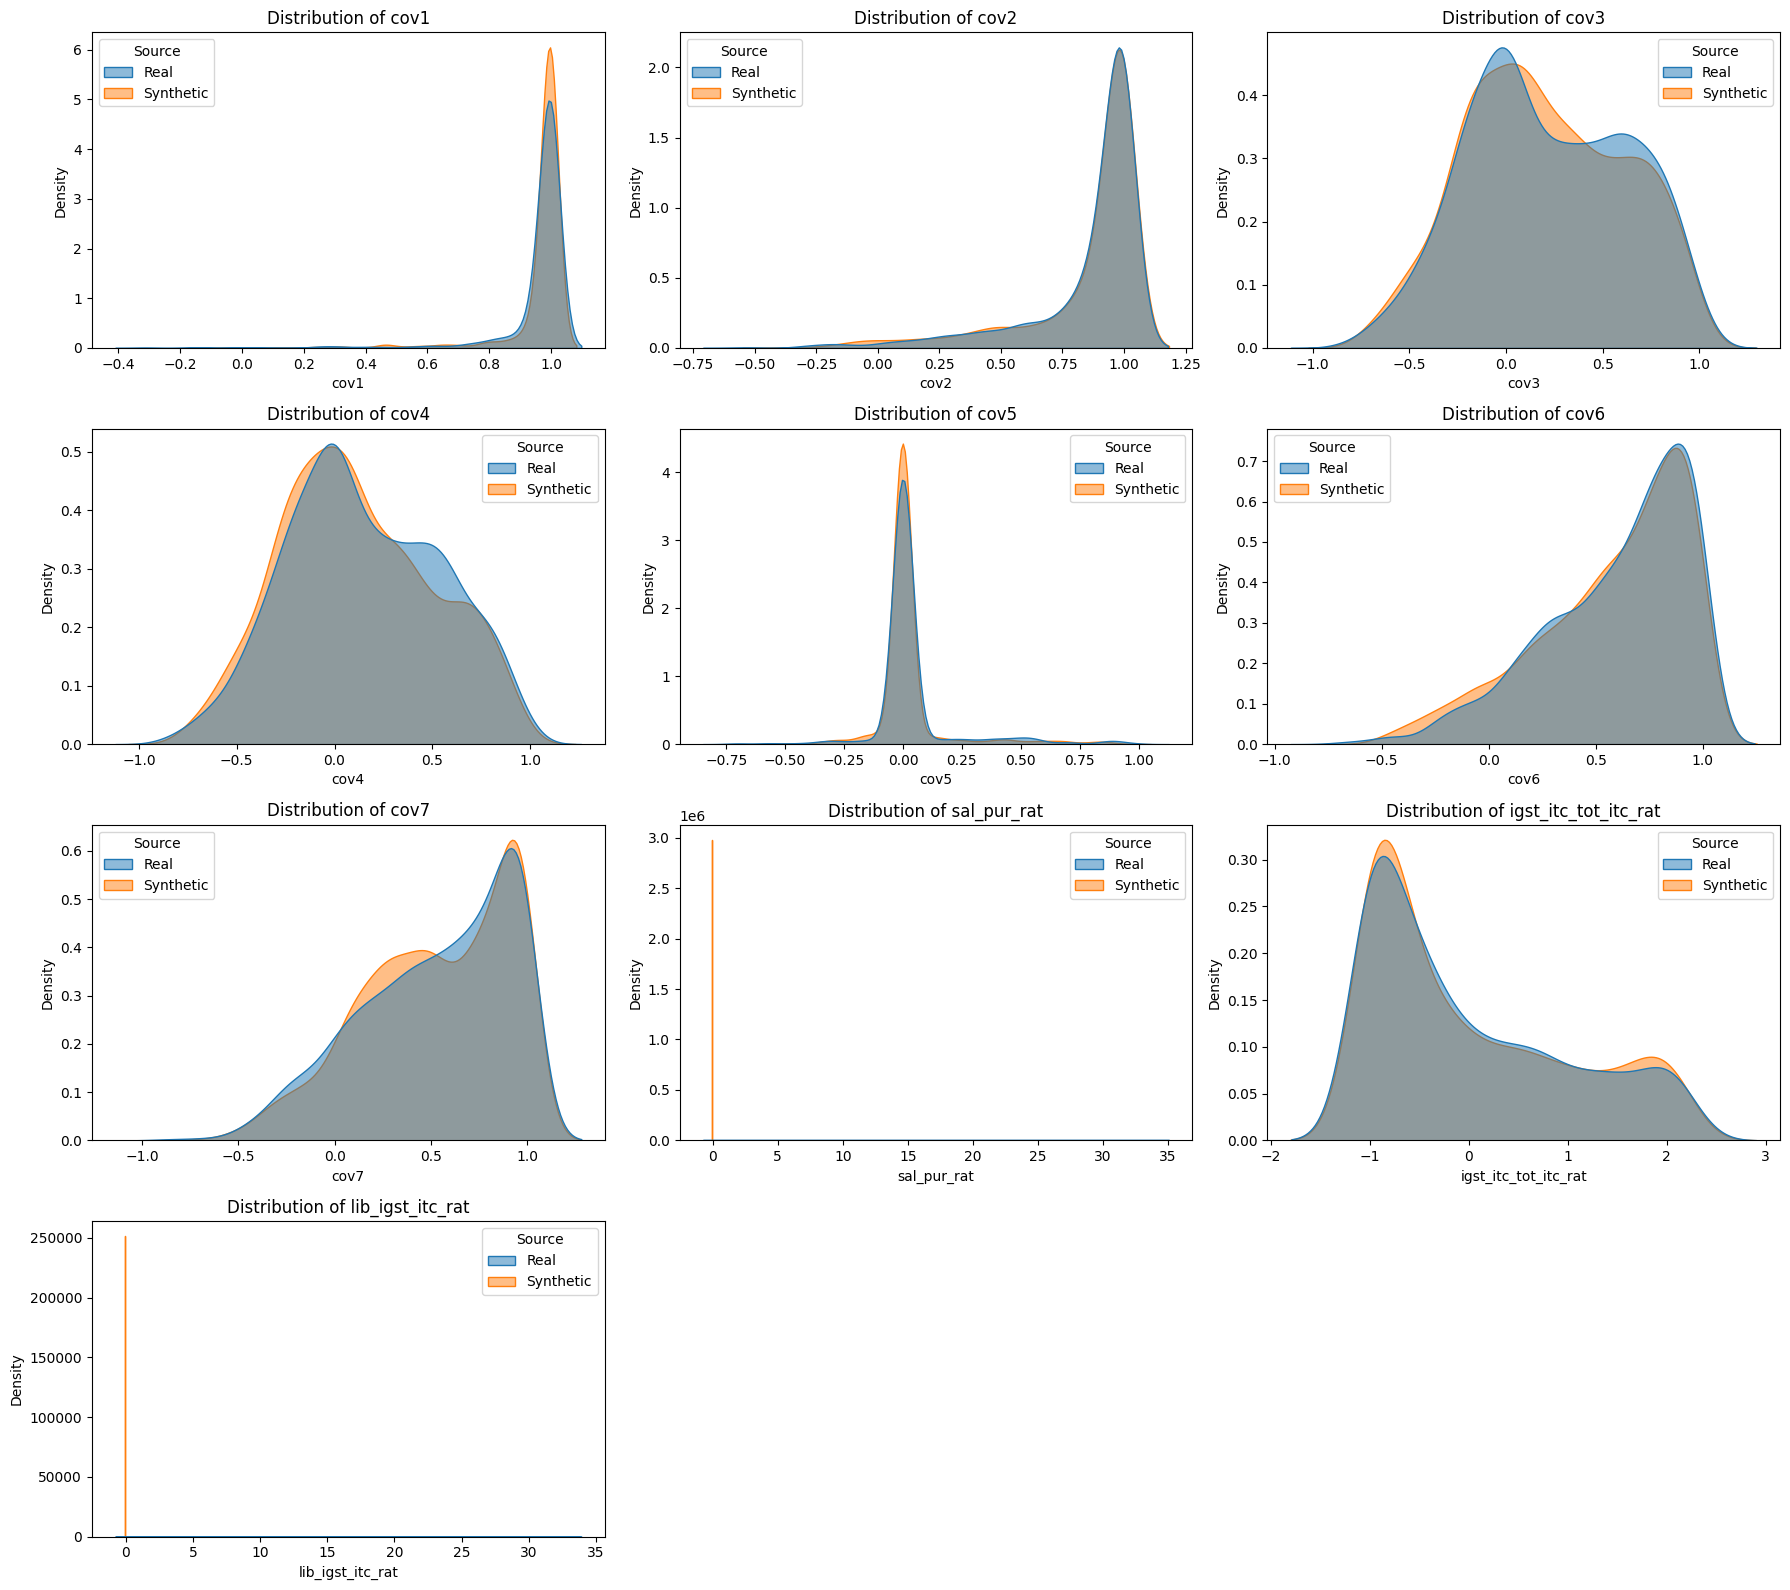

In [ ]:
# --- Plot KDE distributions for all features ---
real_df_labeled = real_df.copy()
real_df_labeled["Source"] = "Real"

fake_df_labeled = fake_df.copy()
fake_df_labeled["Source"] = "Synthetic"

combined_df = pd.concat([real_df_labeled, fake_df_labeled], ignore_index=True)

# Set up the plot grid
num_cols = len(real_df.columns)
ncols = 3
nrows = (num_cols + ncols - 1) // ncols  # ceiling division

plt.figure(figsize=(6 * ncols, 4 * nrows))
for i, col in enumerate(real_df.columns):
    plt.subplot(nrows, ncols, i + 1)
    sns.kdeplot(data=combined_df, x=col, hue="Source", fill=True, alpha=0.5)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()

### Analyze Feature Correlations

This cell compares correlation matrices between real and synthetic data:
- Visualizes Pearson correlation coefficients as heatmaps
- Side-by-side comparison for pattern matching
- Verifies if synthetic data preserves feature dependencies
- Important for maintaining domain-relevant relationships

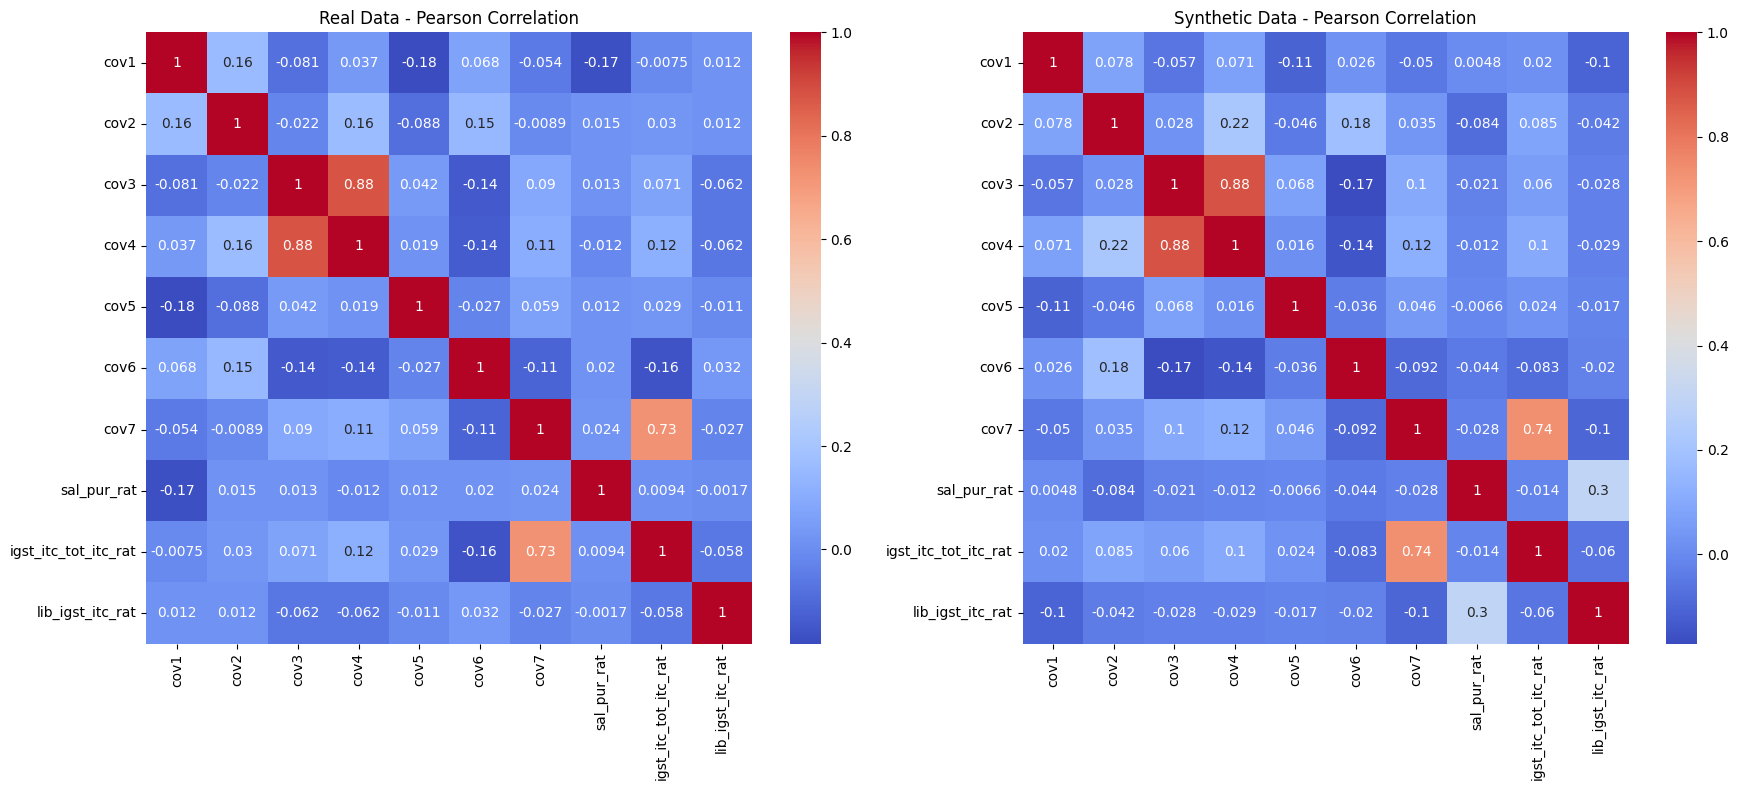

In [ ]:
# --- Compute and visualize Pearson correlation heatmaps ---
real_corr = real_df.corr()
synthetic_corr = fake_df.corr()

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.heatmap(real_corr, annot=True, cmap='coolwarm', ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Real Data - Pearson Correlation', fontsize=14)

sns.heatmap(synthetic_corr, annot=True, cmap='coolwarm', ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('Synthetic Data - Pearson Correlation', fontsize=14)

plt.tight_layout()
plt.show()

### Discriminator Test - Reality Assessment

This cell trains a LogisticRegression classifier to distinguish real vs synthetic data:
- **~50% accuracy**: Classifier guessing randomly = perfect synthetic data
- **>65% accuracy**: Easy to distinguish = poor quality synthetic data
- Tests practical utility: Can the synthetic data fool a simple classifier?
- Includes confusion matrix and classification metrics

In [ ]:
# --- Classification Test: Can a classifier distinguish real vs synthetic? ---
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prepare labeled dataset
real_df_labeled = real_df.copy()
real_df_labeled["label"] = 0  # 0 = Real

fake_df_labeled = fake_df.copy()
fake_df_labeled["label"] = 1  # 1 = Synthetic

# Combine both datasets
combined_df = pd.concat([real_df_labeled, fake_df_labeled], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

X_combined = combined_df.drop("label", axis=1)
y_combined = combined_df["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

# Train logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Classifier Accuracy (Real vs Synthetic): {acc*100:.2f}%")
print("\nInterpretation:")
print("  ~50% = Excellent! Synthetic data is indistinguishable from real data")
print("  >65% = Poor. Classifier can easily detect synthetic data\n")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classifier Accuracy (Real vs Synthetic): 50.28%

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.35      0.43       386
           1       0.47      0.68      0.56       334

    accuracy                           0.50       720
   macro avg       0.52      0.51      0.49       720
weighted avg       0.52      0.50      0.49       720

Confusion Matrix:
 [[136 250]
 [108 226]]


### Compute Correlation Similarity Score

This cell measures how well synthetic data preserves feature relationships:
- Compares Pearson correlation matrices between real and synthetic
- Score near 1.0 = excellent preservation of dependencies
- Score near 0.0 = poor preservation of relationships
- Important for domain applications requiring correlated features

In [ ]:
# --- Calculate Correlation Similarity Score ---
# This measures how well synthetic data preserves feature relationships

real_corr = real_df.corr()
synthetic_corr = fake_df.corr()

# Extract upper triangles (excluding diagonal) for comparison
real_corr_vals = real_corr.where(np.triu(np.ones(real_corr.shape), k=1).astype(bool)).stack()
synthetic_corr_vals = synthetic_corr.where(np.triu(np.ones(synthetic_corr.shape), k=1).astype(bool)).stack()

# Compute similarity as 1 - mean absolute difference
corr_similarity = 1 - np.mean(np.abs(real_corr_vals - synthetic_corr_vals))

print(f"\nCorrelation Similarity Score: {corr_similarity*100:.4f}%")
print("Interpretation:")
print("  >95% = Excellent preservation of feature relationships")
print("  80-95% = Good preservation")
print("  <80% = Poor preservation of dependencies")


Correlation Similarity Score (Original Scale): 95.6208


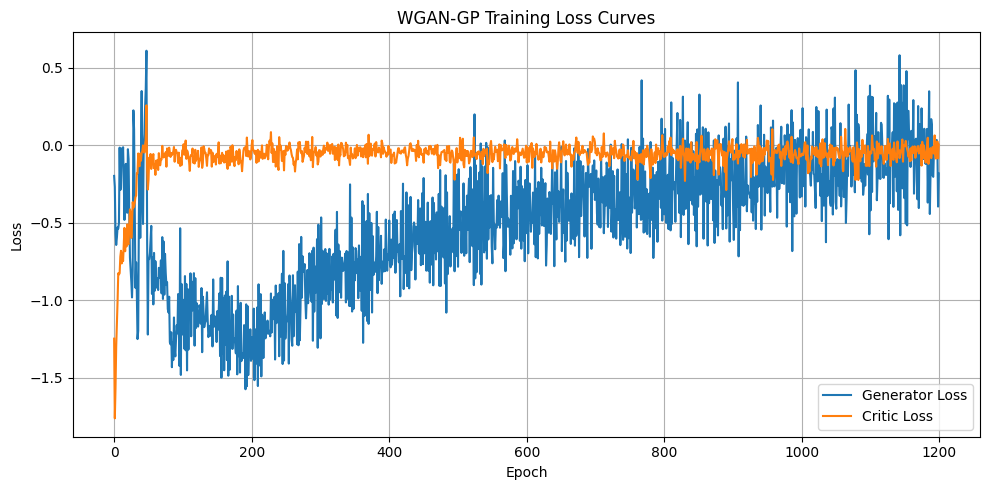

In [ ]:
# --- Plot Training Loss Curves ---
# Monitor generator and discriminator convergence

plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label="Generator Loss", linewidth=2)
plt.plot(crit_losses, label="Critic Loss", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("WGAN-GP Training Loss Curves", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Compute Jensen-Shannon Divergence

This cell calculates statistical distance between distributions:
- **JSD** measures how different two probability distributions are
- Range: 0 (identical) to 1 (completely different)
- Lower JSD = synthetic data better matches real distribution
- Per-feature analysis identifies problematic features

In [ ]:
# --- Compute Jensen-Shannon Divergence (JSD) for each feature ---
# Measures statistical distance between real and synthetic distributions

real_array = real_df[real_df.columns].to_numpy()
synthetic_array = fake_df[fake_df.columns].to_numpy()

print("\n--- Jensen-Shannon Divergence (JSD) for each feature ---")
print("(Lower JSD = better distribution match)\n")

for i, col in enumerate(real_df.columns):
    # Create probability distributions using histograms with same bins
    real_hist, bin_edges = np.histogram(real_array[:, i], bins=100, density=True)
    synth_hist, _ = np.histogram(synthetic_array[:, i], bins=bin_edges, density=True)

    # Add small epsilon to avoid division by zero
    epsilon = 1e-12
    real_hist += epsilon
    synth_hist += epsilon

    # Normalize to valid probability distributions
    real_hist /= real_hist.sum()
    synth_hist /= synth_hist.sum()

    # Calculate JSD
    jsd = jensenshannon(real_hist, synth_hist)
    print(f"{col:25s} JSD: {jsd:.4f}")


--- Jensen-Shannon Divergence (JSD) for each feature ---
cov1                      JSD: 0.1434
cov2                      JSD: 0.1497
cov3                      JSD: 0.1599
cov4                      JSD: 0.1858
cov5                      JSD: 0.3723
cov6                      JSD: 0.1440
cov7                      JSD: 0.1428
sal_pur_rat               JSD: 0.0241
igst_itc_tot_itc_rat      JSD: 0.1677
lib_igst_itc_rat          JSD: 0.0703
